In [1]:
"""
Created on Wed Oct 18 17:46:23 2023

@author: RJha
"""
import os
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

In [3]:
uvth = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/UVTH_Daily.nc')
wv = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/WV_Daily.nc')

uwind = uvth.u
vwind = uvth.v
gph = uvth.z
vort = wv.vo

R1_HW_days = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/Codes/Regime1_hot_days_1973_2022_NM.nc')
R2_HW_days = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/Codes/Regime2_hot_days_1973_2022_NM.nc')

R1_hot_days = R1_HW_days['time'][R1_HW_days['hd'] > 0]
R2_hot_days = R2_HW_days['time'][R2_HW_days['hd'] > 0]

In [4]:
uwind_R1 = uwind.sel(level=[200,500],time=R1_hot_days.time.values)
uwind_R2 = uwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = uwind_R1.latitude.values
lons = uwind_R1.longitude.values
levs = uwind_R1.level.values

diff_R2_R1 = uwind_R2.mean(dim=['time']) - uwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(uwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(uwind_R1[:,k,i,j], uwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


uwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), uwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), uwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
vwind_R1 = vwind.sel(level=[200,500],time=R1_hot_days.time.values)
vwind_R2 = vwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = vwind_R1.latitude.values
lons = vwind_R1.longitude.values
levs = vwind_R1.level.values

diff_R2_R1 = vwind_R2.mean(dim=['time']) - vwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(vwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(vwind_R1[:,k,i,j], vwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


vwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), vwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), vwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
                            
gph_R1 = gph.sel(level=[200,500],time=R1_hot_days.time.values)/9.80665
gph_R2 = gph.sel(level=[200,500],time=R2_hot_days.time.values)/9.80665

lats = gph_R1.latitude.values
lons = gph_R1.longitude.values
levs = gph_R1.level.values

diff_R2_R1 = gph_R2.mean(dim=['time']) - gph_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(gph_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(gph_R1[:,k,i,j], gph_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


gph_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), gph_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), gph_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

######
                       
                        

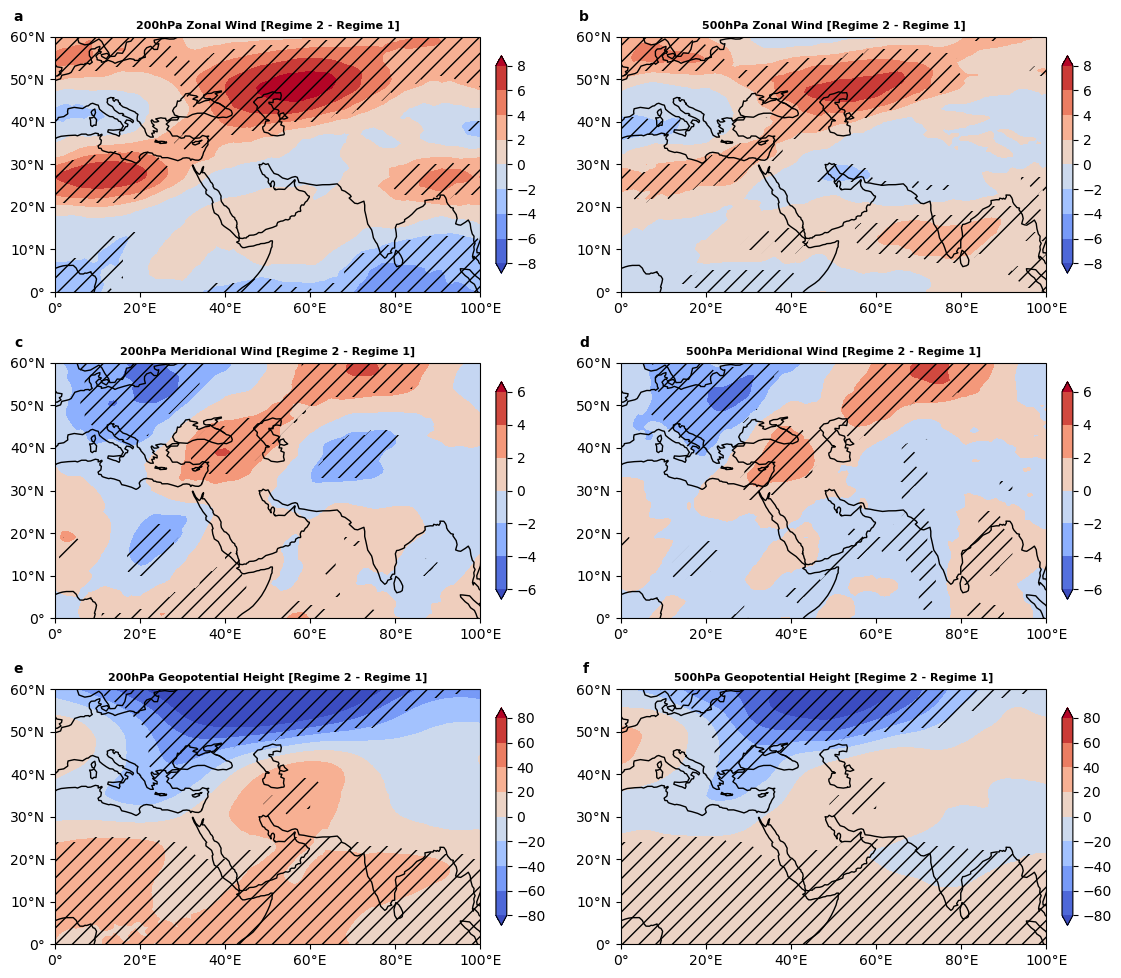

In [5]:

fig = plt.figure(figsize=(14,12))
plev=200

ax1 = plt.subplot2grid(shape=(3,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax1.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(3,4), loc=(1, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax2.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

######

ax3 = plt.subplot2grid(shape=(3,4), loc=(2, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=200)
clevs=np.arange(-80,90,20)
cf_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax3.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###########################################################
plev=500

ax4 = plt.subplot2grid(shape=(3,4), loc=(0, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax4.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax4.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

####

ax5 = plt.subplot2grid(shape=(3,4), loc=(1, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)
ax5.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax5.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax5.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

######

ax6 = plt.subplot2grid(shape=(3,4), loc=(2, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=plev)
clevs=np.arange(-80,90,20)
cf_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax6.yaxis.set_major_formatter(lat_formatter)
ax6.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax6.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax6.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')

plt.savefig('SFigure_4.png', dpi=600,bbox_inches='tight')
plt.savefig('SFigure_4.pdf', dpi=600,bbox_inches='tight')